In [125]:
import numpy as np
import copy
from PIL import Image
import open3d as o3d
import matplotlib.pyplot as plt
from magpie.perception import pcd
from open3d.web_visualizer import draw

In [ ]:
import importlib
importlib.reload(pcd)

In [2]:
from magpie import realsense_wrapper as real
rsc = real.RealSense()
rsc.initConnection()

In [3]:
from magpie.perception.label_owlvit import LabelOWLViT
path = "google/owlvit-base-patch32"
label_vit = LabelOWLViT(path)

In [138]:
from magpie.perception.mask_sam import MaskSAM
ckpt = "/home/will/workspace/owlvit_segment_anything/sam_vit_h_4b8939.pth"
mask_sam = MaskSAM(ckpt)

[445.20769119262695, 0.943225622177124, 655.5901908874512, 181.09984517097473]
[137.63741970062256, 97.50327050685883, 277.07380771636963, 216.3078886270523]
[754.287919998169, 130.4976224899292, 955.7601451873779, 311.0327339172363]
[832.5335597991943, 242.15345084667206, 994.309549331665, 380.5635577440262]
[113.99057388305664, 171.18221640586853, 372.9940605163574, 422.9790937900543]
[349.5113754272461, 185.68095088005066, 571.0792922973633, 424.19286847114563]
[935.6873989105225, 321.5606027841568, 1144.4183444976807, 496.00030839443207]
[420.1651382446289, 376.1610174179077, 659.3386459350586, 585.6181955337524]
[821.7471218109131, 523.7689554691315, 989.4415378570557, 651.8740689754486]
[290.82430839538574, 577.6211196184158, 523.9870929718018, 720.4703682661057]


([([445.20769119262695,
    0.943225622177124,
    655.5901908874512,
    181.09984517097473],
   'onion'),
  ([137.63741970062256,
    97.50327050685883,
    277.07380771636963,
    216.3078886270523],
   'pear'),
  ([754.287919998169, 130.4976224899292, 955.7601451873779, 311.0327339172363],
   'onion'),
  ([832.5335597991943,
    242.15345084667206,
    994.309549331665,
    380.5635577440262],
   'onion'),
  ([113.99057388305664,
    171.18221640586853,
    372.9940605163574,
    422.9790937900543],
   'pear'),
  ([349.5113754272461,
    185.68095088005066,
    571.0792922973633,
    424.19286847114563],
   'onion'),
  ([935.6873989105225,
    321.5606027841568,
    1144.4183444976807,
    496.00030839443207],
   'onion'),
  ([420.1651382446289,
    376.1610174179077,
    659.3386459350586,
    585.6181955337524],
   'pear'),
  ([821.7471218109131,
    523.7689554691315,
    989.4415378570557,
    651.8740689754486],
   'lime'),
  ([290.82430839538574,
    577.6211196184158,
    52

[2337:344][8589] (stun_port.cc:96): Binding request timed out from 192.168.0.x:40128 (enp3s0)


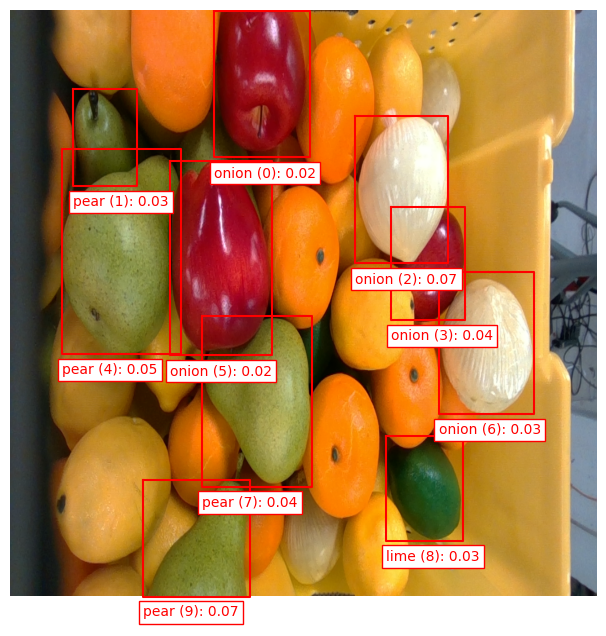

In [104]:
p, rgbd_image = rsc.getPCD()
image = np.array(rgbd_image.color)
queries = ["a photo of an apple", "a photo of a lemon", "a photo of a lime", "a photo of a pear", "a photo of a onion"]
abbrevq = ["apple", "lemon", "lime", "pear", "onion"]
label_vit.set_threshold(0.02)
label_vit.label(image, queries, abbrevq, plot=True)


In [150]:
index = 7
color_copy = copy.deepcopy(rgbd_image.color)
depth_copy = copy.deepcopy(rgbd_image.depth)
dm, rm, imgm = pcd.retrieve_mask_from_image_crop(label_vit.boxes[index][0], rgbd_image)
cpcd = pcd.crop_and_denoise_pcd(dm, rgbd_image, rsc, NB=5)

mc = cpcd.compute_mean_and_covariance()
grasp_pose = [mc[0][1], -mc[0][0], mc[0][2]]
pcaFrame, tmat = pcd.get_pca_frame(mc[0], mc[1], scale=1500.0)
tmat[:3, 3] = grasp_pose
worldFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.075, origin=[0, 0, 0])
geometries = [cpcd, pcaFrame, worldFrame]
draw(geometries)

# despite by my best efforts, I cannot use rgbd_copy. 
# need to reassign color, depth value copies to rgbd_image
# in order to view other crops without having to retake an image
rgbd_image.color = color_copy
rgbd_image.depth = depth_copy


modified indices: [2 0 0]
modified indices: [2 0 1]
tmat: [[ 0.94506831 -0.26542847 -0.19077109 -0.03873094]
 [-0.31977141 -0.87173858 -0.37123859  0.04587254]
 [-0.06776523  0.41184897 -0.90872895  0.23995551]
 [ 0.          0.          0.          1.        ]]
scaled tmat: [[ 0.59321343 -0.03638735 -0.19310431 -0.03873094]
 [-0.2007185  -0.11950587 -0.375779    0.04587254]
 [-0.04253581  0.05646001 -0.9198431   0.23995551]
 [ 0.          0.          0.          1.        ]]
TriangleMesh with 1134 points and 2240 triangles.
[Open3D INFO] Window window_18 created.


WebVisualizer(window_uid='window_18')

[Open3D INFO] Sending init frames to window_18.


[3943:078][8589] (stun_port.cc:96): Binding request timed out from 192.168.0.x:60086 (enp3s0)


In [134]:
tmat

array([[ 0.81600229, -0.5354047 , -0.21790379, -0.01943802],
       [-0.52344845, -0.84434179,  0.11440567,  0.12545837],
       [ 0.24523861, -0.02070611,  0.9692416 ,  0.20089371],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [142]:
# Segmentation Masks
mask_sam.set_image_and_labels(np.array(rgbd_image.color), np.array([np.array(i[0]) for i in label_vit.boxes]), label_vit.labels)


(-0.5, 1279.5, 719.5, -0.5)

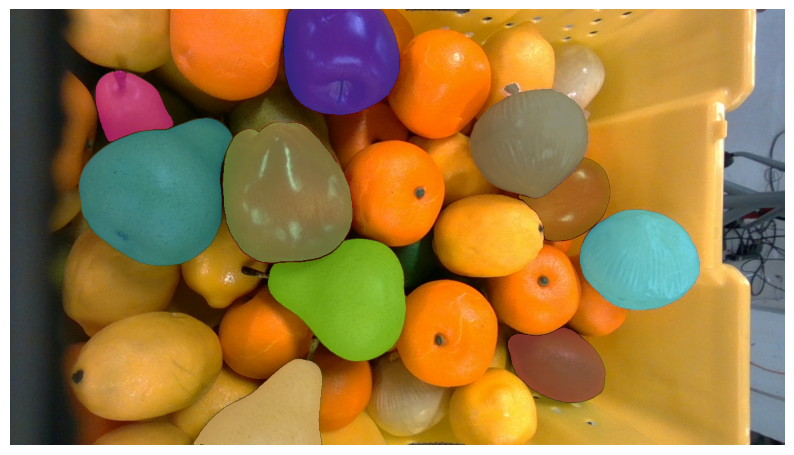

In [145]:
masks = mask_sam.get_masks(label_vit.labels)
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    mask_sam.show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
plt.axis('off')

In [149]:
index = 7
color_copy = copy.deepcopy(rgbd_image.color)
depth_copy = copy.deepcopy(rgbd_image.depth)
mdm = pcd.create_depth_mask_from_mask(np.array(masks[index][0]), rgbd_image.depth)
mcpcd = pcd.crop_and_denoise_pcd(mdm, rgbd_image, rsc, NB=5)

mmc = mcpcd.compute_mean_and_covariance()
m_grasp_pose = [mmc[0][1], -mmc[0][0], mmc[0][2]]
pcaFrame, tmat = pcd.get_pca_frame(mmc[0], mmc[1], scale=2500.0)
tmat[:3, 3] = m_grasp_pose
worldFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.075, origin=[0, 0, 0])
geometries = [mcpcd, pcaFrame, worldFrame]
draw(geometries)

# despite by my best efforts, I cannot use rgbd_copy. 
# need to reassign color, depth value copies to rgbd_image
# in order to view other crops without having to retake an image
rgbd_image.color = color_copy
rgbd_image.depth = depth_copy


modified indices: [1 1 2]
modified indices: [0 1 2]
tmat: [[-0.89007062  0.34805847  0.29432906 -0.02929602]
 [-0.4060017  -0.89889146 -0.16479311  0.04457977]
 [ 0.20721224 -0.26617561  0.94138921  0.23656297]
 [ 0.          0.          0.          1.        ]]
scaled tmat: [[-0.90408658  0.16278576  0.01329705 -0.02929602]
 [-0.41239502 -0.42040847 -0.00744494  0.04457977]
 [ 0.21047521 -0.12448942  0.04252959  0.23656297]
 [ 0.          0.          0.          1.        ]]
TriangleMesh with 1134 points and 2240 triangles.
[Open3D INFO] Window window_17 created.


WebVisualizer(window_uid='window_17')

[Open3D INFO] Sending init frames to window_17.


[3921:046][8589] (stun_port.cc:96): Binding request timed out from 192.168.0.x:46584 (enp3s0)


In [151]:
tmat

array([[ 0.94506831, -0.26542847, -0.19077109,  0.04587254],
       [-0.31977141, -0.87173858, -0.37123859,  0.03873094],
       [-0.06776523,  0.41184897, -0.90872895,  0.23995551],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

[3952:637][8589] (stun_port.cc:96): Binding request timed out from 192.168.0.x:58700 (enp3s0)
